<a href="https://colab.research.google.com/github/sujaysavanth/statisticsfordata/blob/main/Hypothesis4_Energy_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hypothesis 4: Can Energy Usage Be Predicted From Population and Fuel Consumption?

In this notebook, we build a multiple linear regression model to predict total energy usage using:
- Population
- Gasoline consumption (gallons)
- Diesel consumption (gallons)

We evaluate model performance and interpret coefficients to determine predictive power.


In [5]:
!pip install pyxlsb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [7]:
# Load .xlsb file
file_path = "/content/2016cityandcountyenergyprofiles (1).xlsb"
city_data = pd.read_excel(file_path, engine='pyxlsb', sheet_name='City', skiprows=1)
city_data.columns = city_data.iloc[2]
city_data = city_data.drop([0, 1, 2]).reset_index(drop=True)

# Convert relevant columns
mwh_index = list(city_data.columns).index('consumption (MWh)')
tcf_index = list(city_data.columns).index('consumption (TcF)')

city_df = pd.DataFrame()
city_df['population'] = pd.to_numeric(city_data['population'], errors='coerce')
city_df['electricity_MWh'] = pd.to_numeric(city_data.iloc[:, mwh_index], errors='coerce')
city_df['natural_gas_TcF'] = pd.to_numeric(city_data.iloc[:, tcf_index], errors='coerce')

# Total energy
city_df['total_energy_MWh'] = city_df['electricity_MWh'] + city_df['natural_gas_TcF'] * 293071


In [10]:

# Get exact index positions of the duplicate columns
gallon_indexes = city_data.columns.get_indexer_for([col for col in city_data.columns if col == 'consumption (gallons)'])

# gasoline = first, diesel = second
gasoline_series = pd.to_numeric(city_data.iloc[:, gallon_indexes[0]], errors='coerce')
diesel_series = pd.to_numeric(city_data.iloc[:, gallon_indexes[1]], errors='coerce')

city_df['gasoline_gallons'] = gasoline_series
city_df['diesel_gallons'] = diesel_series

# Drop rows with any missing values before modeling
city_df.dropna(subset=['population', 'gasoline_gallons', 'diesel_gallons', 'total_energy_MWh'], inplace=True)



In [11]:
# Define X and y
X = city_df[['population', 'gasoline_gallons', 'diesel_gallons']]
y = city_df['total_energy_MWh']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [12]:
# Predict
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")


R² Score: 0.7961
Mean Absolute Error: 24423419582.70
Mean Squared Error: 12288756392552319418368.00


            Feature   Coefficient
0        population  7.320298e+06
1  gasoline_gallons -1.210229e+04
2    diesel_gallons  1.704951e+04


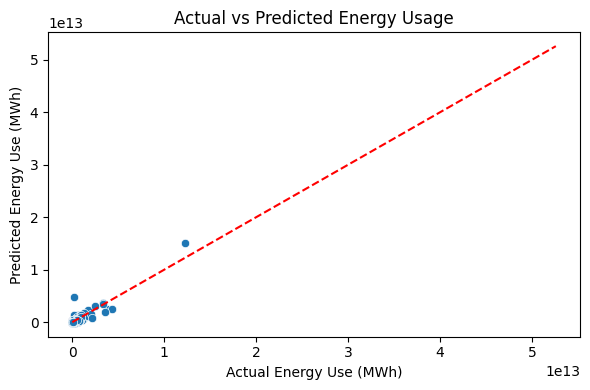

In [13]:
# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coef_df)

# Visualize predictions
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Energy Use (MWh)")
plt.ylabel("Predicted Energy Use (MWh)")
plt.title("Actual vs Predicted Energy Usage")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.tight_layout()
plt.show()
